# Resolução - Projeto da Renner

#### Bibliotecas

In [1]:
#conda install -c conda-forge geopy

In [2]:
#!pip install pulp
#!pip install geopy

import pandas as pd
from pulp import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import geopy.distance

In [3]:
df_CD = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", "Centro de Distribuição")
df_turnos = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", "Turnos")
df_lojas = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", 'Lojas')
df_demanda = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", 'Demanda')
df_veiculos = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", 'Veiculos')

## Apresentação do Case

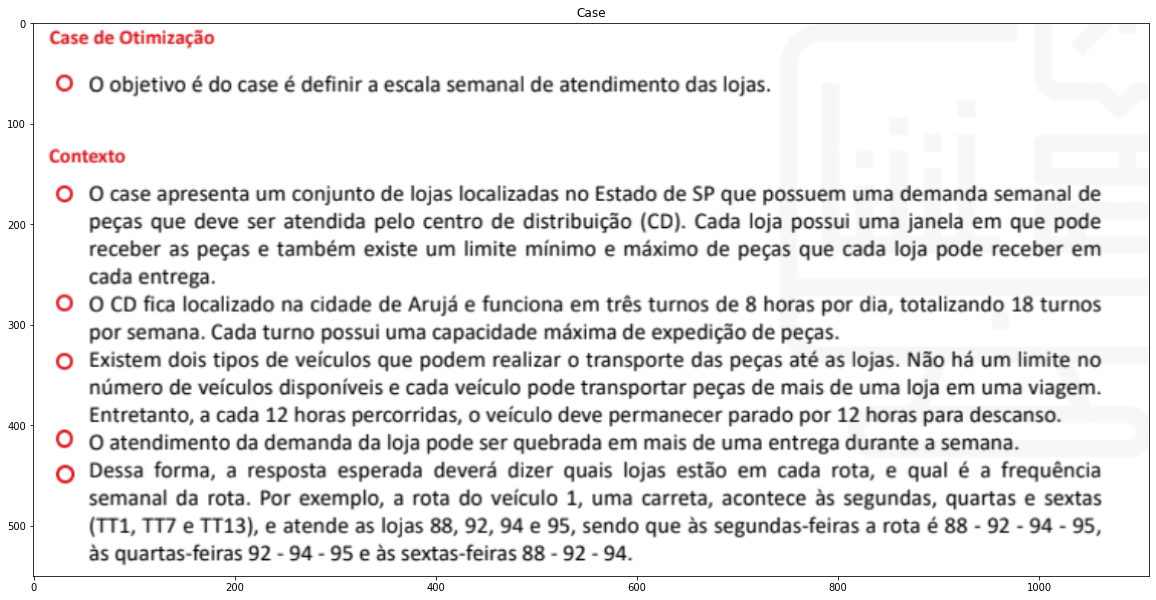

In [4]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.title("Case")
plt.xlabel("")
plt.ylabel("")
 
image = mpimg.imread("Imagens/case.PNG")
plt.imshow(image)
plt.show()

### Restrições do Problema


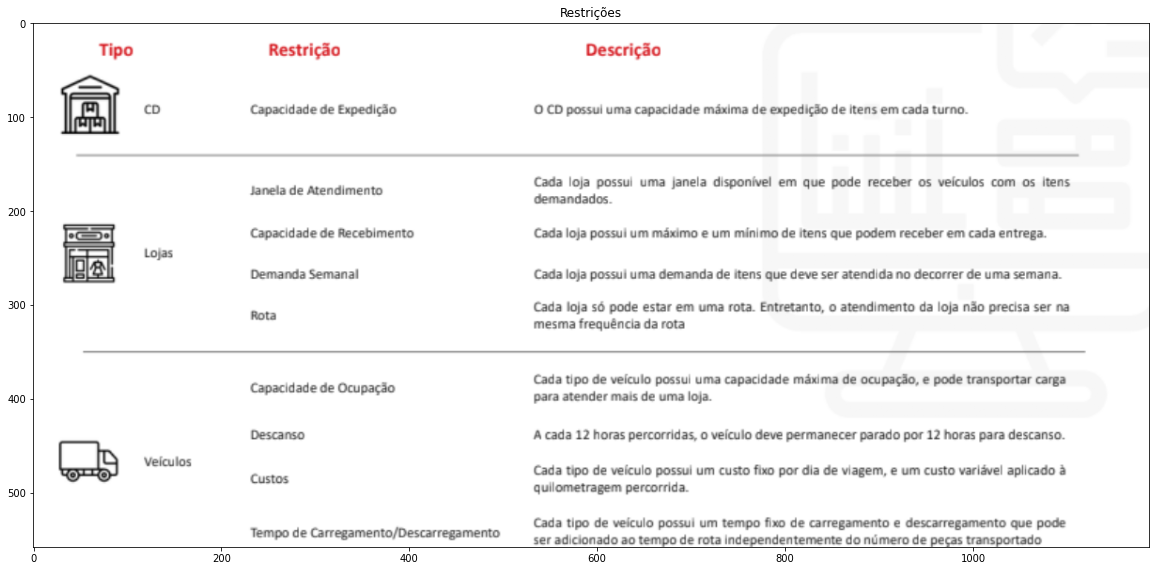

In [5]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.title("Restrições")
plt.xlabel("")
plt.ylabel("")
 
image = mpimg.imread("Imagens/restrictions.PNG")
plt.imshow(image)
plt.show()

## Preparação dos dados

In [6]:
df_lojas.head()

,ID Loja,Município,UF,Latitude,Longitude,SEG,TER,QUA,QUI,SEX,SAB,Hora Recebimento Inicial,Hora Finalização Recebimento,Min. Peças p/ Entrega,Máx. Peças p/ Entrega
0,1.0,BARUERI,SP,-23.504299,-46.834361,x,x,NaN,x,x,NaN,09:00:00,17:00:00,471.0,3138.0
1,2.0,SAO PAULO,SP,-23.529674,-46.676835,x,x,NaN,x,NaN,NaN,09:30:00,17:00:00,519.0,3455.0
2,3.0,SAO PAULO,SP,-23.626342,-46.656541,x,x,x,x,x,NaN,09:00:00,16:00:00,416.0,2773.0
3,4.0,BARUERI,SP,-23.496201,-46.812799,x,NaN,x,x,NaN,NaN,11:00:00,13:00:00,290.0,1931.0
4,5.0,SAO PAULO,SP,-23.541271,-46.575577,x,x,x,x,NaN,NaN,08:30:00,11:30:00,301.0,2006.0


In [7]:
df_CD

,Cidade,UF,Latitude,Longitude
0,Arujá,SP,-23.395082,-46.35536


Juntanto os dataframes do CD e das lojas

In [8]:
import datetime

In [9]:
cd_row = pd.DataFrame({'ID Loja': 0,
                        'Município':df_CD['Cidade'][0], 'UF':df_CD['UF'], 
                       'Latitude':df_CD['Latitude'][0], 'Longitude':df_CD['Longitude'],
                       'SEG': 'x','TER': 'x','QUA': 'x','QUI': 'x','SEX': 'x',
                       'SAB': 'x', 'Hora Recebimento Inicial': datetime.time(0, 0),
                       'Hora Finalização Recebimento': datetime.time(23, 59),
                       'Min. Peças p/ Entrega': 0,
                       'Máx. Peças p/ Entrega': 0,
                       })

In [10]:
df_lojas = pd.concat([cd_row,df_lojas.loc[:]]).reset_index(drop = True)

In [11]:
df_lojas.head(5)

,ID Loja,Município,UF,Latitude,Longitude,SEG,TER,QUA,QUI,SEX,SAB,Hora Recebimento Inicial,Hora Finalização Recebimento,Min. Peças p/ Entrega,Máx. Peças p/ Entrega
0,0.0,Arujá,SP,-23.395082,-46.355360,x,x,x,x,x,x,00:00:00,23:59:00,0.0,0.0
1,1.0,BARUERI,SP,-23.504299,-46.834361,x,x,NaN,x,x,NaN,09:00:00,17:00:00,471.0,3138.0
2,2.0,SAO PAULO,SP,-23.529674,-46.676835,x,x,NaN,x,NaN,NaN,09:30:00,17:00:00,519.0,3455.0
3,3.0,SAO PAULO,SP,-23.626342,-46.656541,x,x,x,x,x,NaN,09:00:00,16:00:00,416.0,2773.0
4,4.0,BARUERI,SP,-23.496201,-46.812799,x,NaN,x,x,NaN,NaN,11:00:00,13:00:00,290.0,1931.0


Obtendo as distâncias entre as coordenadas

In [12]:
def calculate_distance(coords_1,coords_2):
  return float(geopy.distance.geodesic(coords_1, coords_2).m)

In [13]:
def generate_distance_matrix(df):
  distance_matrix = np.zeros((len(df), len(df)))
  for i in range(len(df)):
    for j in range(len(df)):
      coords_1 = (df['Latitude'].iloc[i], df['Longitude'].iloc[i])
      coords_2 = (df['Latitude'].iloc[j], df['Longitude'].iloc[j])
      distance_matrix[i][j] = calculate_distance(coords_1, coords_2)
  return distance_matrix

In [14]:
dmatrix = generate_distance_matrix(df_lojas)

Limpando o dataframe das lojas

In [15]:
df_lojas.drop(['Latitude', 'Longitude'], axis = 1, inplace = True)

## Modelagem do Problema

### Dataframes disponíveis

#### Turnos

In [16]:
df_turnos.head(3)

,Turno,Capacidade Máxima de Expedição
0,TT1,53604.0
1,TT2,56820.0
2,TT3,40200.0


#### Lojas

In [17]:
# Para df_lojas, onde tem X ou x, singnifica que a Loja funciona. Logo, será substituído por 1. Em contrapartida, NaN será 0, pois a loja não funciona.
df_lojas_turnos = ['SEG', 'TER', 'QUA', 'QUI', 'SEX', 'SAB']

df_lojas[df_lojas_turnos] = df_lojas[df_lojas_turnos].replace('X', 1)
df_lojas[df_lojas_turnos] = df_lojas[df_lojas_turnos].replace('x', 1)

df_lojas[df_lojas_turnos] = df_lojas[df_lojas_turnos].replace(np.nan, 0)

In [18]:
df_lojas.head(3)

,ID Loja,Município,UF,SEG,TER,QUA,QUI,SEX,SAB,Hora Recebimento Inicial,Hora Finalização Recebimento,Min. Peças p/ Entrega,Máx. Peças p/ Entrega
0,0.0,Arujá,SP,1.0,1.0,1.0,1.0,1.0,1.0,00:00:00,23:59:00,0.0,0.0
1,1.0,BARUERI,SP,1.0,1.0,0.0,1.0,1.0,0.0,09:00:00,17:00:00,471.0,3138.0
2,2.0,SAO PAULO,SP,1.0,1.0,0.0,1.0,0.0,0.0,09:30:00,17:00:00,519.0,3455.0


Lojas disponíveis por dia da semana:

In [19]:
dict_lojas_SEG = dict(zip(df_lojas['ID Loja'], df_lojas['SEG']))

dict_lojas_TER = dict(zip(df_lojas['ID Loja'], df_lojas['TER']))

dict_lojas_QUA = dict(zip(df_lojas['ID Loja'], df_lojas['QUA']))

dict_lojas_QUI = dict(zip(df_lojas['ID Loja'], df_lojas['QUI']))

dict_lojas_SEX = dict(zip(df_lojas['ID Loja'], df_lojas['SEX']))

dict_lojas_SAB = dict(zip(df_lojas['ID Loja'], df_lojas['SAB']))

Lista dos ai, início da time window do cliente i.

In [20]:
df_lojas['Hora Recebimento Inicial'] = df_lojas['Hora Recebimento Inicial'].apply(lambda x: x.hour + x.minute/60)
a = list(df_lojas['Hora Recebimento Inicial'])
print(a)

[0.0, 9.0, 9.5, 9.0, 11.0, 8.5, 13.0, 6.5, 8.0, 9.0, 9.0, 6.0, 6.0, 8.0, 11.0, 6.0, 6.0, 10.0, 6.0, 13.0, 19.0, 8.0, 9.0, 8.0, 10.0, 9.0, 6.0, 10.0, 10.0, 10.0, 11.0, 6.0, 6.0, 9.0, 10.0, 0.0, 9.0, 9.0, 8.0, 6.0, 0.0, 6.0, 6.0, 6.0, 7.0, 8.0, 9.0, 9.0, 10.0, 9.0, 11.0, 0.0, 6.5, 8.0, 9.0, 0.0, 9.0, 10.0, 8.0, 9.0, 9.5, 9.0, 11.0, 8.5, 13.0, 7.5, 8.0, 9.0, 10.0, 7.0, 11.0, 8.0, 11.0, 10.0, 19.0, 10.0, 11.0, 11.0, 9.0, 9.0, 9.0, 9.0, 10.0, 11.0, 10.0, 13.0, 7.0, 14.0, 10.0, 9.0, 8.0, 10.0, 9.0, 7.0, 7.5, 7.5, 9.0, 10.0, 10.0, 11.0, 10.0, 6.0, 9.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 9.0, 9.0, 11.0, 9.0, 11.0, 10.0, 7.5, 7.5, 0.0, 8.0, 8.0, 10.0, 9.0, 7.0, 8.0, 10.0, 6.5, 7.5, 7.0, 16.0, 12.0, 13.0, 7.0]


Lista dos bi, fim da time window do cliente i.

In [21]:
df_lojas['Hora Finalização Recebimento'] = df_lojas['Hora Finalização Recebimento'].apply(lambda x: x.hour + x.minute/60)
b = list(df_lojas['Hora Finalização Recebimento'])
print(b)

[23.983333333333334, 17.0, 17.0, 16.0, 13.0, 11.5, 15.0, 9.5, 13.0, 11.0, 12.0, 9.0, 12.0, 12.0, 15.0, 10.0, 10.0, 14.0, 9.5, 23.0, 23.0, 12.0, 12.0, 18.0, 15.0, 14.0, 10.0, 16.0, 14.0, 14.0, 17.0, 10.0, 10.0, 13.0, 14.0, 6.0, 14.0, 14.0, 13.0, 11.0, 9.0, 12.0, 10.0, 10.0, 11.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 8.0, 11.5, 18.0, 17.0, 6.0, 13.0, 13.0, 10.0, 17.0, 17.0, 16.0, 13.0, 11.5, 15.0, 7.5, 13.0, 11.0, 12.0, 8.0, 12.0, 12.0, 15.0, 14.0, 20.0, 13.0, 13.0, 13.0, 14.0, 10.5, 9.0, 15.0, 12.0, 17.0, 11.0, 16.0, 9.0, 16.0, 14.0, 14.0, 9.0, 14.0, 16.0, 9.5, 10.0, 9.75, 11.0, 12.0, 14.0, 13.0, 12.0, 10.5, 18.0, 11.0, 13.0, 9.0, 0.0, 14.0, 12.0, 17.0, 15.0, 17.0, 12.5, 17.0, 14.0, 17.0, 16.0, 10.5, 10.5, 8.0, 10.5, 10.0, 17.0, 11.0, 10.0, 10.0, 13.0, 9.0, 11.0, 12.0, 21.0, 18.0, 0.0, 11.0]


#### Demanda

In [22]:
df_demanda.head(3)

,Loja,Peças
0,1.0,3138.0
1,2.0,3455.0
2,3.0,2773.0


In [23]:
cd_demanda = pd.DataFrame({'Loja': [0], 'Peças': [0]})

df_demanda = pd.concat([cd_demanda,df_demanda.loc[:]]).reset_index(drop = True)

In [24]:
demanda = dict(zip(df_demanda['Loja'], df_demanda['Peças'])) # Conversão em dict para facilitar a adição de restrições
print(demanda)

{0.0: 0.0, 1.0: 3138.0, 2.0: 3455.0, 3.0: 2773.0, 4.0: 1931.0, 5.0: 2006.0, 6.0: 2485.0, 7.0: 2047.0, 8.0: 1705.0, 9.0: 2663.0, 10.0: 2035.0, 11.0: 2398.0, 12.0: 1858.0, 13.0: 2640.0, 14.0: 2360.0, 15.0: 2775.0, 16.0: 2415.0, 17.0: 1948.0, 18.0: 3681.0, 19.0: 2009.0, 20.0: 1657.0, 21.0: 2358.0, 22.0: 2617.0, 23.0: 2623.0, 24.0: 2105.0, 25.0: 3033.0, 26.0: 2789.0, 27.0: 1937.0, 28.0: 2767.0, 29.0: 2148.0, 30.0: 2532.0, 31.0: 1479.0, 32.0: 2438.0, 33.0: 2827.0, 34.0: 2295.0, 35.0: 2098.0, 36.0: 1990.0, 37.0: 2374.0, 38.0: 2411.0, 39.0: 2882.0, 40.0: 2067.0, 41.0: 1689.0, 42.0: 2969.0, 43.0: 1432.0, 44.0: 2338.0, 45.0: 2027.0, 46.0: 2466.0, 47.0: 2242.0, 48.0: 1975.0, 49.0: 2190.0, 50.0: 2105.0, 51.0: 1979.0, 52.0: 2529.0, 53.0: 1747.0, 54.0: 2734.0, 55.0: 2473.0, 56.0: 1975.0, 57.0: 2250.0, 58.0: 1545.0, 59.0: 2329.0, 60.0: 4041.0, 61.0: 1618.0, 62.0: 2762.0, 63.0: 1215.0, 64.0: 5127.0, 65.0: 3672.0, 66.0: 4200.0, 67.0: 2531.0, 68.0: 8638.0, 69.0: 3000.0, 70.0: 6480.0, 71.0: 7821.0, 72.0

#### Veículos

In [25]:
df_veiculos.head(3)

,Veículo,Capacidade Máxima (peças),Custo por km,Custo Fixo por dia de viagem,Velocidade,Tempo de carregamento (horas),Tempo de descarregamento (horas)
0,TOCO,5000.0,1.6,100.0,50km/h,0.5,0.5
1,CARRETA,10000.0,2.4,150.0,50km/h,1.0,1.0


In [26]:
custo_km = {'TOCO': 1.6, 'CARRETA': 2.4}
capacidade_max = {'TOCO': 5000, 'CARRETA': 10000}
custos_fixos = {'TOCO': 100, 'CARRETA': 150}
velocidades = {'TOCO': 50000, 'CARRETA': 50000} # em metros/hora
carregamento = {'TOCO': 0.5, 'CARRETA': 1}
descarregamento = {'TOCO': 0.5, 'CARRETA': 1}

### Variáveis

#### Matriz de distâncias

In [27]:
dmatrix

array([[    0.        , 50416.71144727, 36069.26222829, ...,
        40689.71826804, 49989.09257485, 63444.40928971],
       [50416.71144727,     0.        , 16331.4885079 , ...,
        17501.46741049, 16363.58297092, 68899.14545323],
       [36069.26222829, 16331.4885079 ,     0.        , ...,
         7059.06668353, 15203.05471629, 56978.80572027],
       ...,
       [40689.71826804, 17501.46741049,  7059.06668353, ...,
            0.        ,  9301.76087462, 52138.75594522],
       [49989.09257485, 16363.58297092, 15203.05471629, ...,
         9301.76087462,     0.        , 53482.97734947],
       [63444.40928971, 68899.14545323, 56978.80572027, ...,
        52138.75594522, 53482.97734947,     0.        ]])

#### Tempo Mínimo para percorrer a aresta (i,j), de i a j

In [28]:
# O artigo chama essa matrix de d (dij)

d = dmatrix/velocidades['TOCO'] # É a mesma coisa que dmatrix/velocidades['CARRETA'], pois possuem velocidades iguais.

d # Tempos em horas.

array([[0.        , 1.00833423, 0.72138524, ..., 0.81379437, 0.99978185,
        1.26888819],
       [1.00833423, 0.        , 0.32662977, ..., 0.35002935, 0.32727166,
        1.37798291],
       [0.72138524, 0.32662977, 0.        , ..., 0.14118133, 0.30406109,
        1.13957611],
       ...,
       [0.81379437, 0.35002935, 0.14118133, ..., 0.        , 0.18603522,
        1.04277512],
       [0.99978185, 0.32727166, 0.30406109, ..., 0.18603522, 0.        ,
        1.06965955],
       [1.26888819, 1.37798291, 1.13957611, ..., 1.04277512, 1.06965955,
        0.        ]])

#### Demanda de cada cliente

In [29]:
# O artigo chama essa lista de q
# O cliente 0 é o CD, por conveniência
q = list(demanda.values())
print(q)

[0.0, 3138.0, 3455.0, 2773.0, 1931.0, 2006.0, 2485.0, 2047.0, 1705.0, 2663.0, 2035.0, 2398.0, 1858.0, 2640.0, 2360.0, 2775.0, 2415.0, 1948.0, 3681.0, 2009.0, 1657.0, 2358.0, 2617.0, 2623.0, 2105.0, 3033.0, 2789.0, 1937.0, 2767.0, 2148.0, 2532.0, 1479.0, 2438.0, 2827.0, 2295.0, 2098.0, 1990.0, 2374.0, 2411.0, 2882.0, 2067.0, 1689.0, 2969.0, 1432.0, 2338.0, 2027.0, 2466.0, 2242.0, 1975.0, 2190.0, 2105.0, 1979.0, 2529.0, 1747.0, 2734.0, 2473.0, 1975.0, 2250.0, 1545.0, 2329.0, 4041.0, 1618.0, 2762.0, 1215.0, 5127.0, 3672.0, 4200.0, 2531.0, 8638.0, 3000.0, 6480.0, 7821.0, 2895.0, 3635.0, 9196.0, 1350.0, 7510.0, 10553.0, 3428.0, 3687.0, 2089.0, 2235.0, 3817.0, 1355.0, 2906.0, 6805.0, 4885.0, 2876.0, 5055.0, 3343.0, 8865.0, 2046.0, 2038.0, 4966.0, 7983.0, 4997.0, 1898.0, 3257.0, 3574.0, 2042.0, 1714.0, 3850.0, 1517.0, 3208.0, 1160.0, 4134.0, 5123.0, 2699.0, 2388.0, 1814.0, 2502.0, 2667.0, 7770.0, 3344.0, 4491.0, 3504.0, 4158.0, 1012.0, 3901.0, 4370.0, 2204.0, 3371.0, 2122.0, 9103.0, 5227.0, 1

#### Definindo Caminhos e Rotas

In [32]:
# Variáveis binárias xijk que definem se uma rota é (xijk = 1) ou não (xijk = 0) percorrida.
i_pontos = pontos
j_pontos = pontos
k_veiculos = K
x = LpVariable.dicts("Rotas", (i_pontos, j_pontos, k_veiculos), cat=LpBinary)

In [31]:
# Numerando cada um dos nós do grafo.
pontos = list(range(0, 134)) # len(pontos) = 134, vai de 0 (CD) a 133

# Número de clientes
n = len(pontos) - 1 # n = 133 clientes

# Nomes dos veículos.
veiculos = ['TOCO', 'CARRETA'] 

# Definindo o conjunto K com n veículos 'TOCO' e n veículos 'CARRETA'
lista_veiculos = list(range(0, 3*n)) # Teremos 266 veículos
K = [k for k in lista_veiculos]

# Definindo o conjunto Q_til com as capacidades dos veículos de K.
Q_til = list()
for i in range(0, n):
  Q_til.append(capacidade_max['TOCO'])
for i in range(n, 2*n):
  Q_til.append(capacidade_max['CARRETA'])

# Definindo os custos por km por veículo
c = list()
for i in range(0, n):
  c.append(custo_km['TOCO'])
for i in range(n, 2*n):
  c.append(custo_km['CARRETA'])

# Definindo o conjunto F com os custos fixos dos veículos de K.
F = list()
for i in range(0, n):
  F.append(custos_fixos['TOCO'])
for i in range(n, 2*n):
  F.append(custos_fixos['CARRETA'])

# Definindo o conjunto v com as velocidades dos veículos de K
v = list()
for i in range(0, n):
  v.append(velocidades['TOCO'])
for i in range(n, 2*n):
  v.append(velocidades['CARRETA'])

# Definindo Ftil, o custo fixo em termos de tempo
Ftil = list()
for i in range(0, 2*n):
  Ftil.append(F[i] / (c[i] * v[i]))

# Definindo o conjunto sk com os tempos de serviço de cada veículo. (aqui associamos aos veículos, não aos clientes, diferente do artigo).
s = list()
for i in range(0, n):
  s.append(carregamento['TOCO'] + descarregamento['TOCO'])
for i in range(n, 2*n):
  s.append(carregamento['CARRETA'] + descarregamento['CARRETA'])

# Caminhos possíveis entre quaisquer dois pontos do grafo.
Caminhos = [(i, j) for i in pontos for j in pontos]

### Solução trivial

A solução trivial é composta de cada caminhão fazendo viagem de ida e volta para uma única loja. Note que todas as lojas podem ser atendidas uma única vez (embora essa solução possa não ser ótima), pois todas as demandas são menores que a capacidade de uma carreta.

Começa-se com as lojas mais próximas ao CD, enviando caminhões (quando possível, toco, caso contrário, carreta) para as lojas até que se chegue à capacidade máxima de expedição do turno em questão. Ao analisar uma rota, sempre verifica-se se a rota é viável (se o caminhão chegará na loja dentro do tempo de serviço). Caso não seja possível visitar uma loja, ela será analisada novamente no próximo turno.

Note que a solução trivial gasta muitos mais caminhões do que o necessário. 

In [39]:
for turno in range(len(df_turnos)):
	while 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
